### Intro

In [243]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pickle

In [213]:
price = pd.read_csv("./data.csv")
price.head()

,Annual Card Turnover,Average Transaction Amount,MCC Code,Is Registered,Accepts Card,Current Provider,Mastercard Debit,Visa Debit,Mastercard Credit,Visa Credit,Mastercard Business Debit,Visa Business Debit
0,100000,10,5812,Yes,Yes,sumup,0.55% + 2p,0.55% + 2p,0.9% + 2p,0.9% + 2p,1.25% + 2p,1.25% + 2p
1,10000,1000,5561,Yes,Yes,barclaycard,1.75% + 0p,1.75% + 0p,1.75% + 0p,1.75% + 0p,1.75% + 0p,1.75% + 0p
2,60000,307,5734,Yes,Yes,sumup,0.42% + 3p,0.42% + 3p,0.96% + 3p,0.96% + 3p,1.45% + 3p,1.45% + 3p
3,800000,30,8021,Yes,Yes,revolut,0.28% + 2p,0.28% + 2p,0.7% + 2p,0.7% + 2p,1% + 2p,1% + 2p
4,400000,7,5812,Yes,Yes,accept cards,0.4% + 2p,0.4% + 2p,0.8% + 2p,0.8% + 2p,1.05% + 2p,1.05% + 2p


In [214]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Annual Card Turnover        1000 non-null   int64 
 1   Average Transaction Amount  1000 non-null   int64 
 2   MCC Code                    1000 non-null   int64 
 3   Is Registered               1000 non-null   object
 4   Accepts Card                1000 non-null   object
 5   Current Provider            531 non-null    object
 6   Mastercard Debit            1000 non-null   object
 7   Visa Debit                  1000 non-null   object
 8   Mastercard Credit           1000 non-null   object
 9   Visa Credit                 1000 non-null   object
 10  Mastercard Business Debit   1000 non-null   object
 11  Visa Business Debit         1000 non-null   object
dtypes: int64(3), object(9)
memory usage: 93.9+ KB


In [215]:
price.describe()

,Annual Card Turnover,Average Transaction Amount,MCC Code
count,1.000000e+03,1000.00000,1000.000000
mean,2.731635e+05,371.34200,6059.496000
std,1.865396e+06,1237.22371,1463.969271
min,1.500000e+01,1.00000,742.000000
25%,2.000000e+04,15.00000,5651.000000
50%,8.000000e+04,30.00000,5813.000000
75%,2.000000e+05,102.50000,7230.000000
max,5.700000e+07,10157.00000,8999.000000


<Axes: >

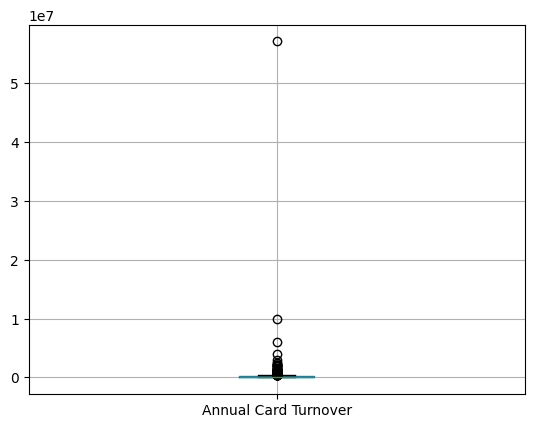

In [216]:
price.boxplot(column=["Annual Card Turnover"])

<Axes: >

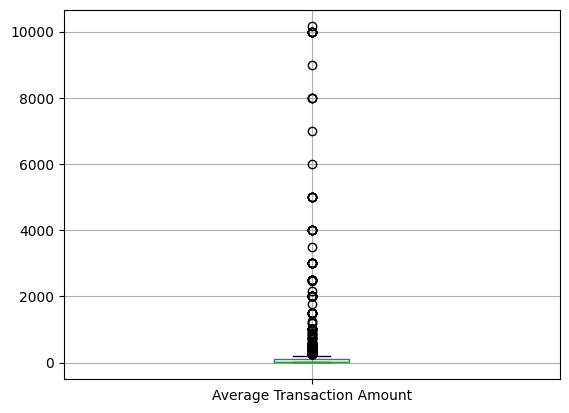

In [217]:
price.boxplot(column=["Average Transaction Amount"])

In [218]:
# 53% currently accept cards

# Need to clean provider name
price["Current Provider"] = price["Current Provider"].str.replace(r'[^a-zA-Z0-9]', '', regex=True).str.upper()

# A few others
price["Current Provider"] = price["Current Provider"].replace({'BARCLAYSS': 'BARCLAYCARD',
                                   'PAYMENTSENCE': 'PAYMENTSENSE',
                                   'TEYAPAYMENTSOLUTIONS': 'TEYA',
                                   'TYLBYNATWEST': 'NATWESTTYL',
                                   'TYLNATWEST': 'NATWESTTYL'
                                  })

# Define probabilities
mastercard_prob = 0.4
visa_prob = 0.6
debit_prob = 0.9
credit_prob = 0.08
business_debit_prob = 0.02

def extract_fees(x):
    percent, pence = x.split('+')
    return [float(percent.strip().strip('%')), float(pence.strip().strip('p'))]

# apply the function to each column
price['Mastercard Debit'] = price['Mastercard Debit'].apply(extract_fees)
price['Visa Debit'] = price['Visa Debit'].apply(extract_fees)
price['Mastercard Credit'] = price['Mastercard Credit'].apply(extract_fees)
price['Visa Credit'] = price['Visa Credit'].apply(extract_fees)
price['Mastercard Business Debit'] = price['Mastercard Business Debit'].apply(extract_fees)
price['Visa Business Debit'] = price['Visa Business Debit'].apply(extract_fees)

# Ensure row-wise operation using axis=1
price['Mastercard Debit'] = price.apply(
    lambda row: row['Mastercard Debit'][0] + (row['Mastercard Debit'][1] / row['Average Transaction Amount']), axis=1
)
price['Visa Debit'] = price.apply(
    lambda row: row['Visa Debit'][0] + (row['Visa Debit'][1] / row['Average Transaction Amount']), axis=1
)
price['Mastercard Credit'] = price.apply(
    lambda row: row['Mastercard Credit'][0] + (row['Mastercard Credit'][1] / row['Average Transaction Amount']), axis=1
)
price['Visa Credit'] = price.apply(
    lambda row: row['Visa Credit'][0] + (row['Visa Credit'][1] / row['Average Transaction Amount']), axis=1
)
price['Mastercard Business Debit'] = price.apply(
    lambda row: row['Mastercard Business Debit'][0] + (row['Mastercard Business Debit'][1] / row['Average Transaction Amount']), axis=1
)
price['Visa Business Debit'] = price.apply(
    lambda row: row['Visa Business Debit'][0] + (row['Visa Business Debit'][1] / row['Average Transaction Amount']), axis=1
)


price["Fees (%)"] = (price["Mastercard Debit"] * mastercard_prob * debit_prob) + \
                (price["Visa Debit"] * visa_prob * debit_prob) + \
                (price["Mastercard Credit"] * mastercard_prob * credit_prob) + \
                (price["Visa Credit"] * visa_prob * credit_prob) + \
                (price["Mastercard Business Debit"] * mastercard_prob * business_debit_prob) + \
                (price["Visa Business Debit"] * visa_prob * business_debit_prob)

price.drop(columns=['Mastercard Debit', 'Visa Debit', 'Mastercard Credit', 'Visa Credit', 'Mastercard Business Debit', 'Visa Business Debit'], inplace=True)

price["Is Registered"] = price["Is Registered"].apply(lambda x:1 if x=='Yes' else 0)
price["Accepts Card"] = price["Accepts Card"].apply(lambda x:1 if x=='Yes' else 0)
price["Current Provider"] = price["Current Provider"].apply(lambda x:0 if pd.isna(x) else x)

price['Annual Card Turnover (log)'] = price['Annual Card Turnover'].apply(lambda x: math.log10(x))
price['Average Transaction Amount (log)'] = price['Average Transaction Amount'].apply(lambda x: math.log10(x))

price.drop(columns=['Annual Card Turnover', 'Average Transaction Amount'], inplace=True)



price.head()


,MCC Code,Is Registered,Accepts Card,Current Provider,Fees (%),Annual Card Turnover (log),Average Transaction Amount (log)
0,5812,1,1,SUMUP,0.792000,5.000000,1.000000
1,5561,1,1,BARCLAYCARD,1.750000,4.000000,3.000000
2,5734,1,1,SUMUP,0.493572,4.778151,2.487138
3,8021,1,1,REVOLUT,0.394667,5.903090,1.477121
4,5812,1,1,ACCEPTCARDS,0.730714,5.602060,0.845098


In [219]:
math.log10(100000)

5.0

### Main

In [220]:
price = price.sample(frac=1)

features = price.drop(columns=["Fees (%)", "Current Provider"])
fees = price["Fees (%)"]

X_train = features[:-200][:]
X_test = features[-200:][:]
y_train = fees[:-200]
y_test = fees[-200:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [244]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

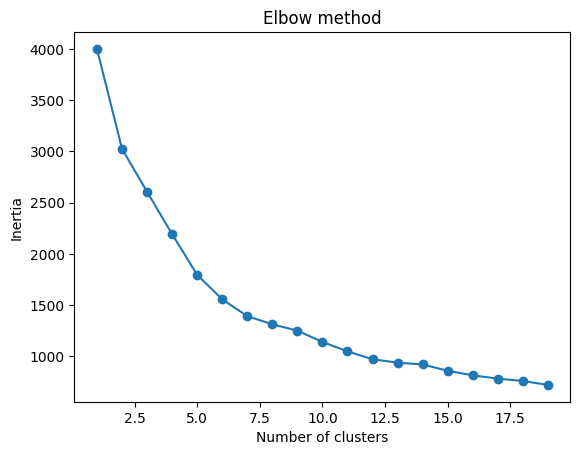

In [221]:
inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i, random_state = 42)
    kmeans.fit(X_train_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [222]:
X_train_scaled

array([[-0.35855285,  0.87077078, -1.05925253,  1.12095319,  1.70110432],
       [-0.27859115,  0.87077078, -1.05925253, -0.06793338, -0.53188069],
       [ 1.58289021, -1.14840785, -1.05925253, -1.25681995, -0.9275295 ],
       ...,
       [-0.57675344,  0.87077078,  0.94406194,  0.61452468,  1.80517357],
       [-0.57675344,  0.87077078, -1.05925253,  0.76306267,  2.32819285],
       [-0.16949086, -1.14840785,  0.94406194,  1.00573818, -0.30044097]])

In [223]:
kmeans = KMeans(n_clusters=6, random_state=42)  # Adjust n_clusters as needed
clusters = kmeans.fit_predict(X_train_scaled)
X_train['cluster'] = clusters

X_train.tail()



,MCC Code,Is Registered,Accepts Card,Annual Card Turnover (log),Average Transaction Amount (log),cluster
94,5511,1,1,5.698970,3.301030,5
435,8641,1,1,4.079181,0.698970,0
389,5211,1,1,5.273001,3.079181,5
68,5211,1,0,5.397940,3.477121,5
942,5812,0,1,5.602060,1.477121,1


In [245]:
with open("kmeans.pkl", "wb") as f:
    pickle.dump(kmeans, f)

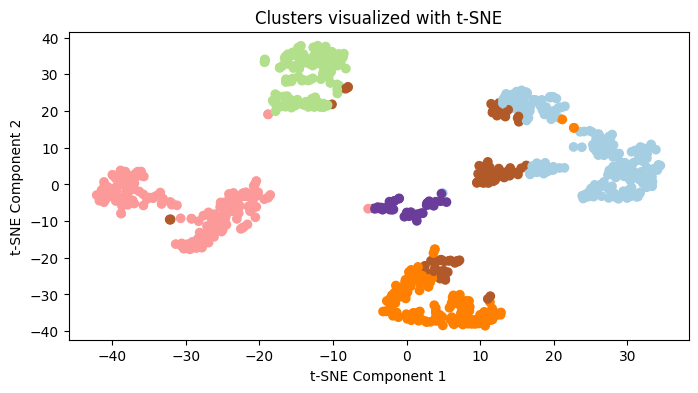

In [224]:
# Visualise with T-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 4))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='Paired')
plt.title("Clusters visualized with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
# plt.colorbar(label="Cluster")
plt.show()

In [225]:
sil_score = silhouette_score(X_train_scaled, clusters)
print(f"Silhouette Score: {sil_score}")

db_score = davies_bouldin_score(X_train_scaled, clusters)
print(f"Davies-Bouldin Index: {db_score}")


Silhouette Score: 0.33702520616681314
Davies-Bouldin Index: 1.1541654524759066


In [226]:
train = X_train.copy()
train["Fees (%)"] = y_train
cluster_stats = train.groupby("cluster")["Fees (%)"].describe()
cluster_stats

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,211.0,0.784486,0.422285,0.341333,0.524433,0.633800,0.8391,3.4838
1,129.0,0.878620,0.381359,0.378000,0.597263,0.725333,1.0000,1.7500
2,193.0,1.269651,0.455016,0.394667,0.856000,1.500000,1.6900,1.7500
3,139.0,1.041664,0.482700,0.377529,0.607200,0.863397,1.5950,1.7500
4,39.0,0.971195,0.500394,0.444667,0.505900,0.836200,1.5000,1.7500
5,89.0,0.663708,0.401589,0.306200,0.465025,0.485800,0.6398,1.7500


In [227]:
train[train["Accepts Card"]==1].groupby("cluster")['Annual Card Turnover (log)'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,211.0,5.148254,0.614959,3.301030,4.778151,5.193125,5.559298,6.342423
1,129.0,4.888807,0.601245,2.698970,4.602060,5.000000,5.301030,6.176091
2,3.0,2.232990,0.807101,1.301030,2.000000,2.698970,2.698970,2.698970
3,3.0,2.301030,0.000000,2.301030,2.301030,2.301030,2.301030,2.301030
4,17.0,5.007939,0.941010,3.477121,4.578731,4.778151,5.397940,7.755875
5,60.0,5.282523,0.544135,4.000000,5.000000,5.224546,5.567742,6.477121


In [228]:
train.groupby("cluster")['Average Transaction Amount (log)'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,211.0,1.438241,0.455536,0.000000,1.161110,1.301030,1.778151,2.301030
1,129.0,1.467001,0.561933,0.301030,1.176091,1.380211,1.698970,3.301030
2,193.0,1.382016,0.504502,0.301030,1.000000,1.301030,1.602060,3.176091
3,139.0,1.614889,0.541371,0.698970,1.176091,1.477121,2.000000,3.000000
4,39.0,2.744530,0.749460,1.477121,2.112655,2.778151,3.301030,4.006765
5,89.0,3.074410,0.424182,2.301030,2.698970,3.079181,3.397940,4.000000


In [229]:

grouped = train.groupby(["cluster", "Accepts Card"]).size().reset_index(name='count')
total_per_cluster = train.groupby("cluster").size().reset_index(name='total')
grouped = grouped.merge(total_per_cluster, on='cluster')
grouped['percentage'] = (grouped['count'] / grouped['total']) * 100
grouped = grouped.sort_values(by=["cluster", "Accepts Card"])
grouped

,cluster,Accepts Card,count,total,percentage
0,0,1,211,211,100.000000
1,1,1,129,129,100.000000
2,2,0,190,193,98.445596
3,2,1,3,193,1.554404
4,3,0,136,139,97.841727
5,3,1,3,139,2.158273
6,4,0,22,39,56.410256
7,4,1,17,39,43.589744
8,5,0,29,89,32.584270
9,5,1,60,89,67.415730


In [230]:
test = X_test.copy()
test["Fees (%)"] = y_test
test['cluster'] = kmeans.predict(X_test_scaled)
test

,MCC Code,Is Registered,Accepts Card,Annual Card Turnover (log),Average Transaction Amount (log),Fees (%),cluster
136,5812,0,0,5.301030,1.301030,1.500000,2
113,8398,0,0,3.000000,0.698970,1.500000,2
783,5814,1,1,5.176091,1.301030,0.607200,0
835,5812,1,0,5.176091,1.176091,0.725333,3
99,5945,0,0,3.000000,1.000000,1.500000,2
...,...,...,...,...,...,...,...
737,5411,1,1,5.653213,1.176091,0.578333,0
692,5411,0,1,4.778151,1.301030,0.739000,1
166,4121,0,1,4.301030,1.255273,1.690000,1
302,7230,1,1,4.397940,1.301030,1.690000,0


In [231]:
grouped_t = test.groupby(["cluster", "Accepts Card"]).size().reset_index(name='count')
total_per_cluster_t = test.groupby("cluster").size().reset_index(name='total')
grouped_t = grouped_t.merge(total_per_cluster_t, on='cluster')
grouped_t['percentage'] = (grouped_t['count'] / grouped_t['total']) * 100
grouped_t = grouped_t.sort_values(by=["cluster", "Accepts Card"])
grouped_t

,cluster,Accepts Card,count,total,percentage
0,0,1,58,58,100.000000
1,1,1,37,37,100.000000
2,2,0,58,58,100.000000
3,3,0,21,21,100.000000
4,4,0,5,8,62.500000
5,4,1,3,8,37.500000
6,5,0,8,18,44.444444
7,5,1,10,18,55.555556


### Prediction

In [232]:
cluster_stats

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,211.0,0.784486,0.422285,0.341333,0.524433,0.633800,0.8391,3.4838
1,129.0,0.878620,0.381359,0.378000,0.597263,0.725333,1.0000,1.7500
2,193.0,1.269651,0.455016,0.394667,0.856000,1.500000,1.6900,1.7500
3,139.0,1.041664,0.482700,0.377529,0.607200,0.863397,1.5950,1.7500
4,39.0,0.971195,0.500394,0.444667,0.505900,0.836200,1.5000,1.7500
5,89.0,0.663708,0.401589,0.306200,0.465025,0.485800,0.6398,1.7500


In [233]:
cluster_stats.columns

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

In [240]:
def classify_fees(train_cluster_stats, test_dataset):
  train_cluster_stats.reset_index(inplace=True)

  test_dataset = test_dataset.merge(train_cluster_stats[["cluster","25%","75%"]], left_on="cluster", right_on="cluster", how="left")

  for idx, price in enumerate(test_dataset["Fees (%)"]):
    if price < test_dataset.loc[idx, '25%']:
      test_dataset.loc[idx, "Fees Classification"] = 'competitive'
    elif price > test_dataset.loc[idx, "75%"]:
      test_dataset.loc[idx, "Fees Classification"] = 'non-competitive'
    else:
      test_dataset.loc[idx, "Fees Classification"] = 'normal'

  return test_dataset

In [241]:
test_dataset = classify_fees(cluster_stats, test)
test_dataset

,MCC Code,Is Registered,Accepts Card,Annual Card Turnover (log),Average Transaction Amount (log),Fees (%),cluster,25%,75%,Fees Classification
0,5812,0,0,5.301030,1.301030,1.500000,2,0.856000,1.6900,normal
1,8398,0,0,3.000000,0.698970,1.500000,2,0.856000,1.6900,normal
2,5814,1,1,5.176091,1.301030,0.607200,0,0.524433,0.8391,normal
3,5812,1,0,5.176091,1.176091,0.725333,3,0.607200,1.5950,normal
4,5945,0,0,3.000000,1.000000,1.500000,2,0.856000,1.6900,normal
...,...,...,...,...,...,...,...,...,...,...
195,5411,1,1,5.653213,1.176091,0.578333,0,0.524433,0.8391,normal
196,5411,0,1,4.778151,1.301030,0.739000,1,0.597263,1.0000,normal
197,4121,0,1,4.301030,1.255273,1.690000,1,0.597263,1.0000,non-competitive
198,7230,1,1,4.397940,1.301030,1.690000,0,0.524433,0.8391,non-competitive


In [242]:
test_dataset["Fees Classification"].value_counts()

,count
Fees Classification,
normal,109
competitive,49
non-competitive,42


In [247]:
cluster_stats.to_csv("cluster_stats.csv", index=False)